## Set Up

### Imports

In [1]:
from warnings import simplefilter

import pandas as pd

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import re
from pathlib import Path
import os

import helpers
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from matplotlib import colormaps
from scipy import stats
from statsmodels.regression import linear_model

# from reload_recursive import reload_recursive
from statsmodels.stats.outliers_influence import variance_inflation_factor

from mri_data import file_manager as fm

### Load Data

#### Clinical and Volumes

In [2]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/figures_tables/assumption_checks"
)

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
)
ventricle_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/paper1/data0/ventricle_volumes.csv",
    index_col="subid",
)
csf_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/data0/csf_volumes2.csv",
    index_col="subid",
)
third_ventricle_width = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/data0/third_ventricle_width.csv",
    index_col="subid",
)

tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
sdmt = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/SDMT_sheet.csv", index_col="subid"
)
df = df.join(
    [
        choroid_volumes,
        ventricle_volumes,
        csf_volumes,
        third_ventricle_width,
        tiv,
        sdmt["SDMT"],
    ]
)
rename_columns = {
    "ventricle_volume": "LV",
    "choroid_volume": "CP",
    "peripheral": "periCSF",
    "all": "allCSF",
    "third_ventricle": "thirdV",
    "third_ventricle_width": "thirdV_width"
}
#! need to fix the actual segmentation files
df.rename(columns=rename_columns, inplace=True)

df["periCSF_frac"] = csf_volumes["peripheral"] / csf_volumes["all"]

df["SDMT"] = pd.to_numeric(df["SDMT"], errors="coerce")
df["thalamus_sqrt"] = np.sqrt(df["thalamus"])
df["thalamus_curt"] = np.sqrt(df["thalamus"] ** 3)
df["cortical_thickness_inv"] = 1 / df["cortical_thickness"]
df["LV_logtrans"] = np.log(df["LV"])

# these corrections should ultimately be made to the csf file
for struct in ["brain", "white", "grey", "thalamus", "t2lv"]:
    df[struct] = df[struct] * 1000

df["CCF"] = df["LV"] / df["allCSF"]
df["peri_ratio"] = df["periCSF"] / df["LV"]


df_z = df.copy()
numeric_cols = df.select_dtypes(include="number").columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

viridis = colormaps["viridis"].resampled(20)

colors = helpers.get_colors()

MS_patients = df["dz_type2"] == "MS"
nonMS_patients = df["dz_type2"] == "!MS"
NIND_patients = df["dz_type5"] == "NIND"
OIND_patients = df["dz_type5"] == "OIND"
RMS_patients = df["dz_type5"] == "RMS"
PMS_patients = df["dz_type5"] == "PMS"

#### HIPS-THOMAS Volumes and Distances

In [3]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
df_thomas_left = pd.read_csv(data_dir / "hipsthomas_left_vols.csv", index_col="subid")
df_thomas_right = pd.read_csv(data_dir / "hipsthomas_right_vols.csv", index_col="subid")

cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col

df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_left = df_thomas_left.rename(columns=new_colnames)
df_thomas_right = df_thomas_right.rename(columns=new_colnames)

nuclei_groupings = {
    "anterior": ["AV_2"],
    "ventral": ["VA_4", "VLa_5", "VLP_6", "VPL_7"],
    "posterior": ["Pul_8", "LGN_9", "MGN_10"],
    "medial": ["MD_Pf_12", "CM_11"],
}


def combine_nuclei(df, groupings):
    df2 = pd.DataFrame()
    for group, nuclei in groupings.items():
        df2[group] = sum([df[nucleus] for nucleus in nuclei])
    return df2


df_thomas = df_thomas.join(combine_nuclei(df_thomas, nuclei_groupings))
df_thomas_left = df_thomas_left.join(combine_nuclei(df_thomas_left, nuclei_groupings))
df_thomas_right = df_thomas_right.join(
    combine_nuclei(df_thomas_right, nuclei_groupings)
)


thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]
deep_grey = [13, 14, 26, 27, 28, 29, 30, 31, 32]
deep_grey_str = [str(i) for i in deep_grey]


hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)["struct"]
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)["index"]

In [4]:
def zscore(df):
    df_z = df.copy()
    numeric_cols = df.select_dtypes(include="number").columns
    df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")
    return df_z

### **Phase 1: Individual Variable Screening (Before Modeling)**

For each continuous variable (predictors AND outcome):

In [5]:
def screen_variable(data, var_name, show=False, save=False, save_dir=None):
    if save_dir is None:
        save_dir = fig_path
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Histogram
    axes[0, 0].hist(data[var_name].dropna(), bins=30, edgecolor='black')
    axes[0, 0].set_title(f'Histogram: {var_name}')
    axes[0, 0].set_xlabel(var_name)

    # Q-Q plot
    stats.probplot(data[var_name].dropna(), dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title(f'Q-Q Plot: {var_name}')

    # Boxplot
    axes[1, 0].boxplot(data[var_name].dropna())
    axes[1, 0].set_title(f'Boxplot: {var_name}')
    axes[1, 0].set_ylabel(var_name)

    # Summary stats
    axes[1, 1].axis('off')
    summary = data[var_name].describe()
    skew = data[var_name].skew()
    kurt = data[var_name].kurtosis()

    summary_text = f"""
    Mean: {summary['mean']:.2f}
    Median: {summary['50%']:.2f}
    Std: {summary['std']:.2f}
    Min: {summary['min']:.2f}
    Max: {summary['max']:.2f}
    
    Skewness: {skew:.2f}
    Kurtosis: {kurt:.2f}
    
    Rule of thumb:
    |Skew| < 1: OK
    |Skew| 1-2: Moderate
    |Skew| > 2: Severe
    """
    axes[1, 1].text(0.1, 0.5, summary_text, fontsize=10, family='monospace')


    plt.tight_layout()
    if save:
        plt.savefig(
            f'{save_dir}/{var_name}_screening.png', dpi=300, bbox_inches='tight'
        )
    if show:
        plt.show()
    else:
        plt.close()

    return skew, kurt

#### **3. Choose Appropriate Transformation**


In [6]:
def suggest_transformation(data, var_name):
    """
    Suggests transformation based on distribution characteristics
    """
    skew = data[var_name].skew()
    has_zeros = (data[var_name] == 0).any()
    has_negatives = (data[var_name] < 0).any()
    
    print(f"\n{var_name} Transformation Recommendations:")
    print(f"Skewness: {skew:.2f}")
    
    if abs(skew) < 1:
        print("→ No transformation needed")
        return False
    
    if skew > 1:  # Right skewed
        print("→ Right-skewed distribution detected")
        if has_negatives:
            print("  ⚠ Has negative values - consider:")
            print("    - Box-Cox (after shifting)")
            print("    - Yeo-Johnson")
        elif has_zeros:
            print("  ⚠ Has zeros - consider:")
            print("    - log(x + 1)")
            print("    - sqrt(x)")
        else:
            print("  Recommended: log(x)")
            print("  Alternative: sqrt(x)")
    
    elif skew < -1:  # Left skewed
        print("→ Left-skewed distribution detected")
        print("  Recommended: square (x²) or reflect + log")
    
    return True


def suggest_transformation(data, var_name):
    """
    Suggests transformation based on distribution characteristics
    """
    skew = data[var_name].skew()
    has_zeros = (data[var_name] == 0).any()
    has_negatives = (data[var_name] < 0).any()
    
    print(f"\n{var_name} Transformation Recommendations:")
    print(f"Skewness: {skew:.2f}")
    
    if abs(skew) < 1:
        print("→ No transformation needed")
        return None
    
    if skew > 1:  # Right skewed
        print("→ Right-skewed distribution detected")
        if has_negatives:
            print("  ⚠ Has negative values - consider:")
            print("    - Box-Cox (after shifting)")
            print("    - Yeo-Johnson")
        elif has_zeros:
            print("  ⚠ Has zeros - consider:")
            print("    - log(x + 1)")
            print("    - sqrt(x)")
        else:
            print("  Recommended: log(x)")
            print("  Alternative: sqrt(x)")
    
    elif skew < -1:  # Left skewed
        print("→ Left-skewed distribution detected")
        print("  Recommended: square (x²) or reflect + log")
    
    return skew

#! will figure something out for boxcox and yeojohnson later if necessary: they both return a 2-tuple
transforms = {
    "log": np.log,
    "log10": np.log10,
    "logp1": np.log1p,
    "sqrt": np.sqrt,
    "boxcox": stats.boxcox,
    "yeojohnson": stats.yeojohnson
}

def apply_transformations(data, var_name, transformations=None):
    """
    Creates multiple transformations for comparison
    """
    if transformations is None:
        transformations = ["log", "log10", "logp1", "sqrt", "boxcox", "yeojohnson"]
        
    transformed = {}
    
    # Original
    transformed['original'] = data[var_name].copy()

    for transform_name in transformations:
        transform_func = transforms[transform_name]
        transformed[transform_name] = transform_func(data[var_name])

    return transformed


def transform_data(data, var_name, transformations=None):
    transformed = apply_transformations(data, var_name, transformations=transformations)
    new_data = data.copy()
    for transform in transformed:
        new_data[f"{var_name}_{transform}"] = transformed[transform]

    return new_data


def apply_transformations0(data, var_name, transformations=None):
    """
    Creates multiple transformations for comparison
    """
    transformed = {}
    
    # Original
    transformed['original'] = data[var_name].copy()
    
    # Log (if no zeros/negatives)
    if (data[var_name] > 0).all():
        transformed['log'] = np.log(data[var_name])
        transformed['log10'] = np.log10(data[var_name])
    
    # Log(x+1) - works with zeros
    if (data[var_name] >= 0).all():
        transformed['log1p'] = np.log1p(data[var_name])
    
    # Square root - works with zeros
    if (data[var_name] >= 0).all():
        transformed['sqrt'] = np.sqrt(data[var_name])
    
    # Box-Cox (requires positive values)
    if (data[var_name] > 0).all():
        transformed, lambda_param = stats.boxcox(data[var_name])
        transformed[f'boxcox(λ={lambda_param:.2f})'] = transformed
    
    # Yeo-Johnson (works with any values)
    transformed, lambda_param = stats.yeojohnson(data[var_name])
    transformed[f'yeojohnson(λ={lambda_param:.2f})'] = transformed
    
    return transformed

def compare_transformations(data, var_name):
    """
    Compares all possible transformations
    """
    trans = apply_transformations(data, var_name)
    
    results = []
    for trans_name, trans_data in trans.items():
        skew = trans_data.skew()
        kurt = trans_data.kurtosis()
        results.append({
            'transformation': trans_name,
            'skewness': skew,
            'kurtosis': kurt,
            'abs_skew': abs(skew)
        })
    
    import pandas as pd
    df_results = pd.DataFrame(results).sort_values('abs_skew')
    
    print(f"\n{var_name} - Transformation Comparison:")
    print(df_results.to_string(index=False))
    
    return df_results

**2. Decision Rules for Transformation**

| Criterion | Action |
|-----------|--------|
| \|Skewness\| > 2 | Strongly consider transformation |
| \|Skewness\| 1-2 | Consider transformation, check residuals first |
| \|Skewness\| < 1 | Probably fine, but still check residuals |
| Heavy outliers (>3 SD) | Investigate; may need robust methods or transformation |


### **Phase 2: Post-Modeling Diagnostics (After Fitting)**


In [7]:
def comprehensive_diagnostics(model, data, save_dir=None):
    """
    Complete diagnostic check suite
    """
    from statsmodels.graphics.gofplots import ProbPlot
    if save_dir is None:
        save_dir = fig_path
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    X = data[model.model.exog_names[1:]]
    X['cont'] = 1
    # Get residuals and fitted values
    residuals = model.resid
    fitted = model.fittedvalues
    standardized_resid = (residuals - residuals.mean()) / residuals.std()
    
    # Studentized residuals
    from statsmodels.stats.outliers_influence import OLSInfluence
    influence = OLSInfluence(model)
    studentized_resid = influence.resid_studentized_internal
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    
    # 1. Residuals vs Fitted (Linearity & Homoscedasticity)
    axes[0, 0].scatter(fitted, residuals, alpha=0.5)
    axes[0, 0].axhline(y=0, color='r', linestyle='--')
    axes[0, 0].set_xlabel('Fitted values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs Fitted\n(Check: linearity, homoscedasticity)')
    
    # Add lowess line
    from statsmodels.nonparametric.smoothers_lowess import lowess
    lowess_line = lowess(residuals, fitted, frac=0.3)
    axes[0, 0].plot(lowess_line[:, 0], lowess_line[:, 1], 'g-', linewidth=2)
    
    # 2. Q-Q plot (Normality of residuals)
    ProbPlot(standardized_resid).qqplot(line='45', ax=axes[0, 1])
    axes[0, 1].set_title('Q-Q Plot\n(Check: normality of residuals)')
    
    # 3. Scale-Location (Homoscedasticity)
    axes[0, 2].scatter(fitted, np.sqrt(np.abs(standardized_resid)), alpha=0.5)
    axes[0, 2].set_xlabel('Fitted values')
    axes[0, 2].set_ylabel('√|Standardized residuals|')
    axes[0, 2].set_title('Scale-Location\n(Check: homoscedasticity)')
    lowess_line = lowess(np.sqrt(np.abs(standardized_resid)), fitted, frac=0.3)
    axes[0, 2].plot(lowess_line[:, 0], lowess_line[:, 1], 'r-', linewidth=2)
    
    # 4. Residuals histogram
    axes[1, 0].hist(standardized_resid, bins=30, edgecolor='black')
    axes[1, 0].set_xlabel('Standardized Residuals')
    axes[1, 0].set_title('Histogram of Residuals\n(Check: normality)')
    
    # 5. Cook's Distance (Influential points)
    cooks_d = influence.cooks_distance[0]
    axes[1, 1].stem(range(len(cooks_d)), cooks_d, markerfmt=',')
    axes[1, 1].axhline(y=4/len(cooks_d), color='r', linestyle='--', 
                       label="Cook's D threshold (4/n)")
    axes[1, 1].set_xlabel('Observation')
    axes[1, 1].set_ylabel("Cook's Distance")
    axes[1, 1].set_title("Cook's Distance\n(Check: influential points)")
    axes[1, 1].legend()
    
    # 6. Leverage vs Residuals
    leverage = influence.hat_matrix_diag
    axes[1, 2].scatter(leverage, studentized_resid, alpha=0.5)
    axes[1, 2].axhline(y=0, color='r', linestyle='--')
    axes[1, 2].axhline(y=2, color='orange', linestyle='--', alpha=0.5)
    axes[1, 2].axhline(y=-2, color='orange', linestyle='--', alpha=0.5)
    axes[1, 2].set_xlabel('Leverage')
    axes[1, 2].set_ylabel('Studentized Residuals')
    axes[1, 2].set_title('Residuals vs Leverage\n(Check: influential outliers)')
    
    # 7-9: Residuals vs each predictor (for linearity check)
    predictor_cols = X.columns[:3] if len(X.columns) >= 3 else X.columns
    for idx, col in enumerate(predictor_cols):
        ax = axes[2, idx]
        ax.scatter(X[col], residuals, alpha=0.5)
        ax.axhline(y=0, color='r', linestyle='--')
        ax.set_xlabel(col)
        ax.set_ylabel('Residuals')
        ax.set_title(f'Residuals vs {col}\n(Check: linearity)')
        # Add lowess
        lowess_line = lowess(residuals, X[col], frac=0.3)
        ax.plot(lowess_line[:, 0], lowess_line[:, 1], 'g-', linewidth=2)
    
    plt.tight_layout()
    plt.savefig(f'{save_dir}/diagnostic_plots.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Statistical tests
    print("\n" + "="*60)
    print("STATISTICAL TESTS")
    print("="*60)
    
    # 1. Shapiro-Wilk (normality of residuals)
    shapiro_stat, shapiro_p = stats.shapiro(residuals)
    print("\n1. Shapiro-Wilk Test (Normality of Residuals):")
    print(f"   Statistic: {shapiro_stat:.4f}, p-value: {shapiro_p:.4f}")
    print(f"   {'✓ PASS' if shapiro_p > 0.05 else '✗ FAIL'} - Residuals {'are' if shapiro_p > 0.05 else 'are NOT'} normally distributed")
    
    # 2. Breusch-Pagan (homoscedasticity)
    from statsmodels.stats.diagnostic import het_breuschpagan
    bp_stat, bp_p, _, _ = het_breuschpagan(residuals, X)
    print("\n2. Breusch-Pagan Test (Homoscedasticity):")
    print(f"   Statistic: {bp_stat:.4f}, p-value: {bp_p:.4f}")
    print(f"   {'✓ PASS' if bp_p > 0.05 else '✗ FAIL'} - Variance {'is' if bp_p > 0.05 else 'is NOT'} constant")
    
    # 3. Durbin-Watson (independence/autocorrelation)
    from statsmodels.stats.stattools import durbin_watson
    dw_stat = durbin_watson(residuals)
    print("\n3. Durbin-Watson Test (Independence):")
    print(f"   Statistic: {dw_stat:.4f}")
    print(f"   {'✓ PASS' if 1.5 < dw_stat < 2.5 else '⚠ WARNING'} - Residuals {'show no' if 1.5 < dw_stat < 2.5 else 'may show'} autocorrelation")
    print("   (DW ≈ 2 is ideal; <1 or >3 is problematic)")
    
    # 4. VIF (multicollinearity)
    print("\n4. Variance Inflation Factor (Multicollinearity):")
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif_data.to_string(index=False))
    print("   Rule: VIF < 5 is good; 5-10 is moderate; >10 is problematic")
    
    # 5. Influential points summary
    print("\n5. Influential Points:")
    n_high_cooks = (cooks_d > 4/len(cooks_d)).sum()
    print(f"   Points with high Cook's D (>4/n): {n_high_cooks}")
    if n_high_cooks > 0:
        high_cooks_idx = np.where(cooks_d > 4/len(cooks_d))[0]
        print(f"   Indices: {high_cooks_idx[:10]}")  # Show first 10
    
    n_high_leverage = (leverage > 2*X.shape[1]/len(leverage)).sum()
    print(f"   Points with high leverage (>2p/n): {n_high_leverage}")
    
    # 6. Outliers
    n_outliers = (np.abs(studentized_resid) > 3).sum()
    print("\n6. Outliers:")
    print(f"   Points with |studentized residuals| > 3: {n_outliers}")
    
    print("\n" + "="*60)
    
    return influence, cooks_d, leverage


def run_comprehensive_dx(model: linear_model.RegressionResultsWrapper, data: pd.DataFrame, save_path):
    # Run diagnostics
    X = data[model.model.exog_names[1:]]
    y = data[model.model.endog_names]
    comprehensive_diagnostics(model, X, y, data, save_path)


## Complete Workflow

In [10]:
all_vars = [
    "LV",
    "CP",
    "periCSF",
    "allCSF",
    "thirdV",
    "thirdV_width",
    "THALAMUS_1",
    "medial",
    "posterior",
    "ventral",
    "anterior",
    "t2lv",
    "PRL", 
    "cortical_thickness",
    "brain",
    "white",
    "grey",
]

data = df.join(df_thomas)[MS_patients]

In [ ]:
print("="*70)
print("PHASE 1: VARIABLE SCREENING")
print("="*70)


# Screen all variables
save_dir = fig_path / "screening"
transformations_needed = []
for var in all_vars:
    skew, kurt = screen_variable(data, var, save=True, save_dir=save_dir)
    if abs(skew) > 1:
        transformations_needed.append(var)
        suggest_transformation(data, var)

Transform the variables and recheck them

In [19]:
prl_transformed = transform_data(data, "PRL", transformations=["logp1", "sqrt"])
for var in ["logp1", "sqrt"]:
    col = f"PRL_{var}"
    screen_variable(prl_transformed, col, save=True, save_dir=save_dir)

screen_variable(prl_transformed, "PRL", save=True, save_dir=save_dir)

(np.float64(3.462898310952633), np.float64(16.154759684513582))

In [20]:
suggest_transformation(prl_transformed, "PRL_logp1")


PRL_logp1 Transformation Recommendations:
Skewness: 1.37
→ Right-skewed distribution detected
  ⚠ Has zeros - consider:
    - log(x + 1)
    - sqrt(x)


np.float64(1.3743278556265233)

(array([302.,   0.,  66.,   0.,  50.,  30.,   5.,   9.,   3.,   3.]),
 array([0.        , 0.27080502, 0.54161004, 0.81241506, 1.08322008,
        1.3540251 , 1.62483012, 1.89563514, 2.16644016, 2.43724518,
        2.7080502 ]),
 <BarContainer object of 10 artists>)

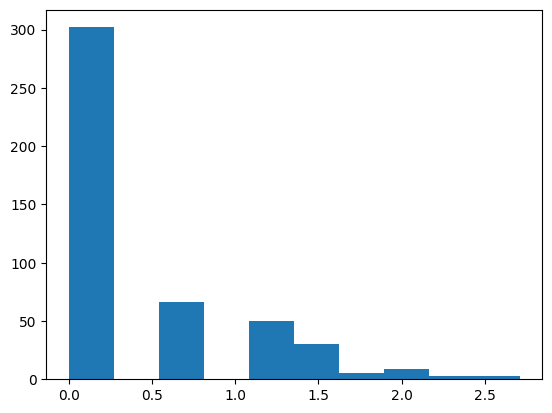

In [22]:
plt.hist(np.log1p(data['PRL']))

In [10]:
models = {}
for var in all_vars:
    formula = f"{var} ~ age + Female + tiv"
    models[var] = sm.OLS.from_formula(formula, data=data).fit()

In [ ]:
import os 

outcome = "CP"
model_data = data[~data[outcome].isna()]
save_dir = fig_path / outcome
if not save_dir.exists():
    os.makedirs(save_dir)
run_comprehensive_dx(models[outcome], model_data, save_dir)

/home/srs-9/.virtualenvs/ms_mri/lib/python3.13/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),



STATISTICAL TESTS

1. Shapiro-Wilk Test (Normality of Residuals):
   Statistic: 0.9974, p-value: 0.6864
   ✓ PASS - Residuals are normally distributed

2. Breusch-Pagan Test (Homoscedasticity):
   Statistic: 8.3174, p-value: 0.0399
   ✗ FAIL - Variance is NOT constant

3. Durbin-Watson Test (Independence):
   Statistic: 2.1201
   ✓ PASS - Residuals show no autocorrelation
   (DW ≈ 2 is ideal; <1 or >3 is problematic)

4. Variance Inflation Factor (Multicollinearity):
Variable        VIF
     age   1.031330
  Female   1.423534
     tiv   1.395076
    cont 258.098274
   Rule: VIF < 5 is good; 5-10 is moderate; >10 is problematic

5. Influential Points:
   Points with high Cook's D (>4/n): 26
   Indices: [  6  13  27  53  69  71  83  86 122 154]
   Points with high leverage (>2p/n): 24

6. Outliers:
   Points with |studentized residuals| > 3: 2



In [22]:
def complete_regression_check(data, outcome_var, predictor_vars, covariates=[]):
    """
    Complete workflow from screening to diagnostics
    """
    import statsmodels.api as sm
    
    print("="*70)
    print("PHASE 1: VARIABLE SCREENING")
    print("="*70)
    
    # Screen all variables
    all_vars = [outcome_var] + predictor_vars + covariates
    transformations_needed = {}
    
    for var in all_vars:
        print(f"\n--- Screening {var} ---")
        skew, kurt = screen_variable(data, var)
        suggest_transformation(data, var)
        
        if abs(skew) > 1:
            print(f"\n⚠ {var} may need transformation")
            trans_results = compare_transformations(data, var)
            transformations_needed[var] = trans_results
    
    print("\n" + "="*70)
    print("PHASE 2: MODEL FITTING")
    print("="*70)
    
    # Prepare data (apply chosen transformations here)
    X = data[predictor_vars + covariates].copy()
    y = data[outcome_var].copy()
    
    # Add constant
    X = sm.add_constant(X)
    
    # Fit model
    model = sm.OLS(y, X).fit()
    print(model.summary())
    
    print("\n" + "="*70)
    print("PHASE 3: DIAGNOSTIC CHECKS")
    print("="*70)
    
    # Run diagnostics
    influence, cooks_d, leverage = comprehensive_diagnostics(
        model, X, y, data
    )
    
    # Decision summary
    print("\n" + "="*70)
    print("RECOMMENDATIONS")
    print("="*70)
    
    if transformations_needed:
        print("\n⚠ Variables needing attention:")
        for var in transformations_needed:
            print(f"  - {var}")
        print("\nRecommendation: Apply transformations and re-run analysis")
    else:
        print("\n✓ All variables look reasonable")
    
    return model, influence


def model_diagnostics(res: linear_model.RegressionResultsWrapper, data: pd.DataFrame):
    # Run diagnostics
    X = data[res.model.endog_names]
    y = data[res.model.exog_names]
    influence, cooks_d, leverage = comprehensive_diagnostics(
        res, X, y, data
    )
    
    # Decision summary
    print("\n" + "="*70)
    print("RECOMMENDATIONS")
    print("="*70)
    
    if transformations_needed:
        print("\n⚠ Variables needing attention:")
        for var in transformations_needed:
            print(f"  - {var}")
        print("\nRecommendation: Apply transformations and re-run analysis")
    else:
        print("\n✓ All variables look reasonable")
    
    return res, influence
# Usage example:
# model, influence = complete_regression_check(
#     data=df,
#     outcome_var='CP',
#     predictor_vars=['predictor', 'LV'],
#     covariates=['THALAMUS_1', 'age', 'Female', 'tiv']
# )

In [8]:
def compare_count_transformations(data, count_var, outcome, covariates=['age', 'Female', 'tiv']):
    """
    Compare different transformations of a count predictor
    """
    import statsmodels.api as sm
    
    # Create transformations
    data[f'{count_var}_log1p'] = np.log1p(data[count_var])
    data[f'{count_var}_sqrt'] = np.sqrt(data[count_var])
    
    transformations = {
        'raw': count_var,
        'log(x+1)': f'{count_var}_log1p',
        'sqrt': f'{count_var}_sqrt'
    }
    
    results = {}
    
    for trans_name, trans_var in transformations.items():
        print(f"\n{'='*70}")
        print(f"Testing: {trans_name}")
        print(f"{'='*70}")
        
        # Build model: outcome ~ count_transform + covariates
        model_vars = [trans_var] + covariates
        df_model = data[[outcome] + model_vars].dropna()
        
        X = df_model[model_vars].copy()
        y = df_model[outcome].copy()
        X = sm.add_constant(X)
        
        # Fit
        model = sm.OLS(y, X).fit()
        
        # Get diagnostics
        residuals = model.resid
        fitted = model.fittedvalues
        
        # Key metrics
        from scipy import stats
        shapiro_stat, shapiro_p = stats.shapiro(residuals)
        
        from statsmodels.stats.diagnostic import het_breuschpagan
        bp_stat, bp_p, _, _ = het_breuschpagan(residuals, X)
        
        # Distribution of predictor
        pred_skew = df_model[trans_var].skew()
        
        results[trans_name] = {
            'model': model,
            'predictor_skew': pred_skew,
            'residuals_normal_p': shapiro_p,
            'homoscedastic_p': bp_p,
            'r_squared': model.rsquared,
            'aic': model.aic,
            'coef': model.params[trans_var],
            'p_value': model.pvalues[trans_var]
        }
        
        print(f"\nPredictor skewness: {pred_skew:.3f}")
        print(f"Residuals normal (p): {shapiro_p:.3f}")
        print(f"Homoscedastic (p): {bp_p:.3f}")
        print(f"R²: {model.rsquared:.3f}")
        print(f"AIC: {model.aic:.1f}")
        print(f"\nCoefficient for {trans_var}: {model.params[trans_var]:.4f} (p={model.pvalues[trans_var]:.4f})")
    
    # Summary comparison
    print(f"\n{'='*70}")
    print("COMPARISON SUMMARY")
    print(f"{'='*70}")
    
    comparison_df = pd.DataFrame(results).T
    comparison_df = comparison_df[['predictor_skew', 'residuals_normal_p', 
                                     'homoscedastic_p', 'r_squared', 'aic']]
    print(comparison_df.to_string())
    
    # Recommendation
    print(f"\n{'='*70}")
    print("RECOMMENDATION")
    print(f"{'='*70}")
    
    # Find best by AIC and assumption tests
    best_aic = comparison_df['aic'].idxmin()
    best_skew = comparison_df['predictor_skew'].abs().idxmin()
    
    print(f"Lowest AIC: {best_aic}")
    print(f"Lowest |skewness|: {best_skew}")
    
    return results, comparison_df

# Usage:
# results, comparison = compare_count_transformations(
#     data=df,
#     count_var='PRL_count',
#     outcome='CP',
#     covariates=['age', 'Female', 'tiv']
# )

In [12]:
results, comparison_df = compare_count_transformations(data, "PRL", "CP", covariates=['age', 'Female', 'tiv'])



Testing: raw

Predictor skewness: 3.463
Residuals normal (p): 0.291
Homoscedastic (p): 0.021
R²: 0.246
AIC: 7042.9

Coefficient for PRL: 55.0497 (p=0.0000)

Testing: log(x+1)

Predictor skewness: 1.374
Residuals normal (p): 0.385
Homoscedastic (p): 0.030
R²: 0.239
AIC: 7047.2

Coefficient for PRL_log1p: 145.3445 (p=0.0000)

Testing: sqrt

Predictor skewness: 1.332
Residuals normal (p): 0.387
Homoscedastic (p): 0.029
R²: 0.238
AIC: 7047.3

Coefficient for PRL_sqrt: 112.4012 (p=0.0000)

COMPARISON SUMMARY
         predictor_skew residuals_normal_p homoscedastic_p r_squared          aic
raw            3.462898           0.290962        0.020516  0.245598  7042.864613
log(x+1)       1.374328           0.384715        0.029516  0.238509   7047.24147
sqrt           1.332171           0.386689        0.029198  0.238411  7047.301948

RECOMMENDATION
Lowest AIC: raw
Lowest |skewness|: sqrt


(array([  1.,   7.,  20.,  58., 100., 139.,  97.,  33.,   9.,   4.]),
 array([-1593.204996  , -1291.1084189 ,  -989.0118418 ,  -686.9152647 ,
         -384.81868761,   -82.72211051,   219.37446659,   521.47104369,
          823.56762079,  1125.66419789,  1427.76077498]),
 <BarContainer object of 10 artists>)

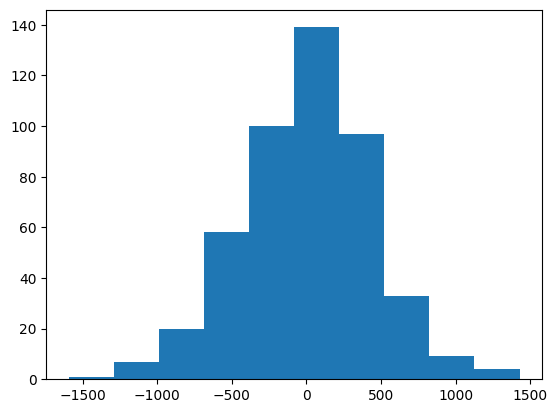

In [15]:
plt.hist(results['raw']['model'].resid)

(array([  3.,   4.,  20.,  30.,  84., 138., 114.,  51.,  17.,   6.]),
 array([-1487.31418314, -1222.08423694,  -956.85429073,  -691.62434452,
         -426.39439831,  -161.1644521 ,   104.06549411,   369.29544032,
          634.52538652,   899.75533273,  1164.98527894]),
 <BarContainer object of 10 artists>)

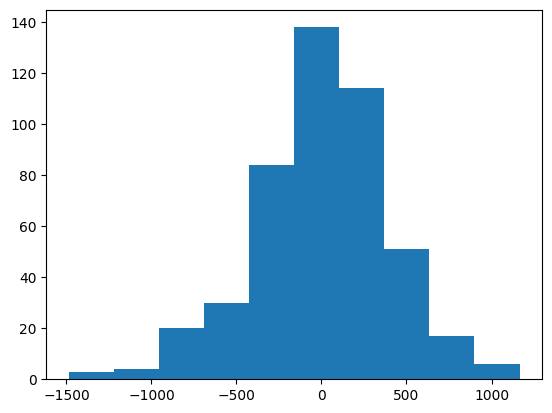

In [18]:
formula = "CP ~ LV + age + Female + tiv"
model = sm.OLS.from_formula(formula, data=data).fit()
plt.hist(model.resid)